<a href="https://colab.research.google.com/github/elias9080dm/XenoTox_Colab/blob/main/QSAR_Classification_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Observaciones***

Falta:



*   Mostrar nombres correctos en el gráfico SHAP (no feature_000)
*   Mejorar rendimiento de entrenamiento modificando n_jobs (actualmente -2)
*   Verificar si es necesario conservar la función de limpieza antes del entrenamiento (ya se limpian los datos en el pipeline)
*   Verificar si es neceario conservar SMOTE antes del entrenamiento (el pipeline ya tiene SMOTE)


*   Modificar el código para que el valor de la variable de "model_name" no se pierda en la celda shap (actualmente aparece como "individual_model" en lugar de mostrar el modelo utilizado rf/xgb/svm/knn)
*   Mejoras en la predicción externa (añadir comentarios escritos sobre los resultados obtenidos
* Modificar la forma en que se guardan los modelos para permitir integrarlos al flujo de "MultiTargetQSAR"







# **QSAR Clasificación Binaria**

Inspirado en el artículo de Kotli et al. (2025), este cuaderno permite construir modelos QSAR binarios sobre datos desbalanceados.

**Incluye:**
- Modelos Random Forest, XGBoost, SVM, KNN
- Balanceo de clases (SMOTE)
- Métrica principal: MCC
- Interpretabilidad con SHAP
- Y-scrambling
- Curva de cobertura
- Dominio de aplicabilidad (Leverage)
- Guardado automático de modelos, gráficas y métricas

## **1. Imports**

In [ ]:
# Instalación de librerías necesarias
%pip install pandas numpy scikit-learn scikit-optimize xgboost rdkit shap optuna bayesian-optimization


In [ ]:
# General
import os, shap, joblib
from joblib import Parallel, delayed
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
import warnings
import contextlib, sys

# Curación de RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger


# Machine Learning
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from collections import Counter

# Métricas
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

# Balanceo y pipelines
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Hiperoptimización
import optuna
from skopt import BayesSearchCV
from skopt.space import Real as SkReal, Integer as SkInteger, Categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import clone, BaseEstimator, TransformerMixin

## **2. Configuración**

In [ ]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive')

# Crear carpetas

BASE_DIR = "/content/drive/MyDrive/QSAR"
os.makedirs(f"{BASE_DIR}/outputs/models", exist_ok=True)
os.makedirs(f"{BASE_DIR}/outputs/plots", exist_ok=True)
os.makedirs(f"{BASE_DIR}/outputs/reports", exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === CONFIGURACIÓN MANUAL ===
target_name = 'ahr'  # 'ahr', 'car', 'pxr' OJO: Los archivos deben llamarse "ahr_ligands.csv, car_ligands.csv, pxr_ligands.csv"
model_name = 'xgb'  # 'rf', 'xgb', 'svm', 'knn'
use_stacking = True
use_hyperopt = True
hyperopt_method = 'optuna'  # 'optuna'
n_jobs = -1  # Cambiado de -2 a -1 para usar todos los CPUs disponibles
random_state = 42
proba_thresholds = [round(x, 2) for x in np.arange(0.1, 1.0, 0.1)]

## **3. Curación de base de datos**

In [ ]:
# Apagar logs de RDKit
RDLogger.DisableLog('rdApp.*')

# Función de curación
def curate_csv_data(csv_path, smiles_col="SMILES", activity_col="Activity"):
    df_raw = pd.read_csv(csv_path)
    initial_count = len(df_raw)

    # 1. Eliminar NaNs
    df = df_raw.dropna(subset=[smiles_col, activity_col]).copy()

    # 2. Convertir a molécula RDKit
    df["mol"] = df[smiles_col].apply(Chem.MolFromSmiles)
    df = df[df["mol"].notnull()].copy()

    # 3. Estandarización
    lfc = rdMolStandardize.LargestFragmentChooser()
    normalizer = rdMolStandardize.Normalizer()
    reionizer = rdMolStandardize.Reionizer()
    uncharger = rdMolStandardize.Uncharger()

    def standardize(mol):
        try:
            mol = lfc.choose(mol)
            mol = normalizer.normalize(mol)
            mol = reionizer.reionize(mol)
            mol = uncharger.uncharge(mol)
            return mol
        except:
            return None

    df["mol_std"] = df["mol"].apply(standardize)
    df = df[df["mol_std"].notnull()].copy()

    # 4. Generar SMILES canónico estandarizado
    df["SMILES_std"] = df["mol_std"].apply(Chem.MolToSmiles)

    # 5. Eliminar duplicados
    df = df.drop_duplicates(subset="SMILES_std").copy()

    # 6. Resetear índices y renombrar columnas estándar
    df = df[[activity_col, "SMILES_std"]].rename(columns={"SMILES_std": "SMILES"})
    df = df.reset_index(drop=True)

    final_count = len(df)
    print(f"Curación completa: {final_count} moléculas válidas (de {initial_count} iniciales).")
    return df

# Usar la función de curación en el archivo CSV correspondiente
out_path = f"{BASE_DIR}/{target_name}_ligands.csv"
df = curate_csv_data(out_path)
display(df.head())


Curación completa: 7483 moléculas válidas (de 8020 iniciales).


,Activity,SMILES
0,Active,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2
1,Active,O=C(O)c1cccc(-c2noc(-c3ccccc3F)n2)c1
2,Active,Cc1nc(-c2ccc(OCC(C)C)c(C#N)c2)sc1C(=O)O
3,Active,COc1c2ccoc2cc2oc(=O)ccc12
4,Active,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12


## **4. Cálculo de descriptores**

In [ ]:
# 1. Definimos la función de cálculo (la misma que tenías)
def calcular_descriptores(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return [func(mol) for _, func in Descriptors._descList]

# 2. Configuración de hilos (Ajustado al número real de CPUs disponibles)
from psutil import cpu_count
n_cores = cpu_count()

print(f"Iniciando cálculo en paralelo con {n_cores} núcleos...")

# 3. Ejecución paralela
# Convertimos a lista para joblib y usamos tqdm para ver el progreso
smiles_list = df['SMILES'].tolist()
resultados = Parallel(n_jobs=n_cores)(
    delayed(calcular_descriptores)(s) for s in tqdm(smiles_list, desc="Progreso RDKit")
)

# 4. Post-procesamiento y Alineación
# Creamos un Series temporal para usar la lógica de dropna() y mantener índices
desc_series = pd.Series(resultados, index=df.index)
desc_clean = desc_series.dropna()

# 5. Crear X como DataFrame
feature_names = [name for name, _ in Descriptors._descList]
X = pd.DataFrame(desc_clean.tolist(), index=desc_clean.index, columns=feature_names)

# 6. Etiquetas y DataFrame original alineados
y = df.loc[desc_clean.index, "Activity"].values
df_curated = df.loc[desc_clean.index].reset_index(drop=True)

# 7. Reporte final
print(f"\n✅ Proceso completado.")
print(f"Dataset: {target_name} | Moléculas finales: {len(X)} | Descriptores: {X.shape[1]}")

# Guardar CSV curado
os.makedirs("outputs/reports", exist_ok=True)
out_path = f"outputs/reports/{target_name}_curated_df.csv"
df_curated.to_csv(out_path, index=False)
print(f"Archivo guardado en: {out_path}")

Iniciando cálculo en paralelo con 2 núcleos...


Progreso RDKit: 100%|██████████| 7483/7483 [01:31<00:00, 81.86it/s] 



✅ Proceso completado.
Dataset: ahr | Moléculas finales: 7483 | Descriptores: 217
Archivo guardado en: outputs/reports/ahr_curated_df.csv


### 4.1 Visualizar distribución de clases

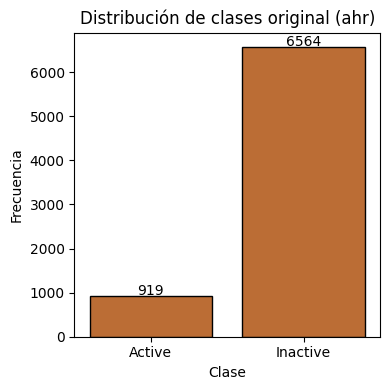

Histograma guardado en: /content/drive/MyDrive/QSAR/outputs/plots/ahr_initial_class_distribution.png


In [ ]:
# Histograma de clases en la base de datos curada
activity_col = "Activity"
plt.figure(figsize=(4, 4))
ax = sns.countplot(x=activity_col, data=df, edgecolor='black', color='chocolate', legend=False)
plt.title(f"Distribución de clases original ({target_name})")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{int(height)}", (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', xytext=(0, -1), textcoords='offset points')

plt.tight_layout()

# Guardar figura
out_path = f"{BASE_DIR}/outputs/plots/{target_name}_initial_class_distribution.png"
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Histograma guardado en: {out_path}")


## **5. División estratificada**

In [ ]:
# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=random_state)

# Convertir X_train y X_test a DataFrame para mantener columnas e índices
X_train = pd.DataFrame(X_train, columns=X.columns, index=X.index[X_train.index])
X_test = pd.DataFrame(X_test, columns=X.columns, index=X.index[X_test.index])

## **6. Modelos base**

In [ ]:
model_dict = {
    "rf": RandomForestClassifier(n_estimators=100, class_weight="balanced", n_jobs=n_jobs, random_state=random_state),
    "xgb": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", n_jobs=n_jobs, random_state=random_state, tree_method='auto'),
    "svm": SVC(kernel='rbf', probability=True, class_weight="balanced", random_state=random_state),
    "knn": KNeighborsClassifier(n_neighbors=5)
}

## **7. Hiperoptimización Optuna**

In [ ]:
# === CLEAN TRANSFORMER ===
class CleanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, clip_value=1e6):
        self.clip_value = clip_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.nan_to_num(X, nan=0.0,
                          posinf=self.clip_value,
                          neginf=-self.clip_value)
        return np.clip(X, -self.clip_value, self.clip_value)

# === Función segura de StratifiedKFold ===
def safe_stratified_kfold(y, max_folds=5, shuffle=True, random_state=42):
    min_class_count = min(Counter(y).values())
    n_splits = min(max_folds, min_class_count)
    if n_splits < 2:
        raise ValueError(f"No se puede usar validación cruzada: solo hay {min_class_count} muestras en la clase menor.")
    return StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

# === BUILD PIPELINE ===
def build_pipeline(model, smote_k):
    return Pipeline([
        ("clean", CleanTransformer()),
        ("imputer", SimpleImputer(strategy="median")),
        ("smote", SMOTE(k_neighbors=smote_k, random_state=random_state)),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

# === MAIN OPTIMIZATION FUNCTION ===
def optimize_model(X, y, model_name, hyperopt_method):

    # Codificación y cálculo de smote_k
    le = LabelEncoder()
    y = le.fit_transform(y)
    min_class = min(Counter(y).values())
    smote_k = max(1, min(min_class - 1, 5))

    # Selección del modelo base
    if model_name == "xgb":
        base_model = XGBClassifier(eval_metric="logloss", random_state=random_state,
                                  n_jobs=n_jobs, tree_method="hist")

    elif model_name == "rf":
        base_model = RandomForestClassifier(n_jobs=n_jobs, random_state=random_state)

    elif model_name == "svm":
        base_model = SVC(probability=True, random_state=random_state, kernel='rbf')

    elif model_name == "knn":
        base_model = KNeighborsClassifier(n_jobs=n_jobs)

    else:
        raise ValueError(f"Modelo no soportado: {model_name}")

    # Pipeline y validación cruzada
    pipe = build_pipeline(base_model, smote_k)
    cv = safe_stratified_kfold(y, max_folds=5, random_state=random_state)

    # Solo Optuna para simplificar
    if hyperopt_method != "optuna":
        raise ValueError("Solo se soporta 'optuna' en esta versión simplificada")

    def objective(trial):
        # Definir espacios de búsqueda específicos para cada modelo
        if model_name == "xgb":
            params = {
                "model__max_depth": trial.suggest_int("model__max_depth", 3, 7),
                "model__learning_rate": trial.suggest_float("model__learning_rate", 0.01, 0.3, log=True),
                "model__n_estimators": trial.suggest_int("model__n_estimators", 100, 500)
            }
        elif model_name == "rf":
            params = {
                "model__max_depth": trial.suggest_int("model__max_depth", 5, 30),
                "model__n_estimators": trial.suggest_int("model__n_estimators", 100, 500)
            }
        elif model_name == "svm":
            params = {
                "model__C": trial.suggest_float("model__C", 0.1, 10, log=True),
                "model__gamma": trial.suggest_float("model__gamma", 0.001, 1, log=True)
            }
        elif model_name == "knn":
            params = {
                "model__n_neighbors": trial.suggest_int("model__n_neighbors", 3, 15),
                "model__weights": trial.suggest_categorical("model__weights", ['uniform', 'distance']),
                "model__p": trial.suggest_int("model__p", 1, 2)
            }

        trial_pipe = build_pipeline(clone(base_model), smote_k)
        trial_pipe.set_params(**params)

        scores = cross_val_score(
            trial_pipe,
            X,
            y,
            scoring="matthews_corrcoef",
            cv=cv,
            n_jobs=n_jobs
        )

        return scores.mean()

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=25)

    # Entrenar modelo final
    final_pipe = build_pipeline(base_model, smote_k)
    final_pipe.set_params(**study.best_params)
    final_pipe.fit(X, y)

    return final_pipe, le

## **8. Entrenamiento y stacking**

In [ ]:
# Función de limpieza avanzada antes de evaluación
def clean_input(X, clip_value=1e4):
    # Reemplazar NaN, inf, -inf
    X = np.nan_to_num(X, nan=0.0, posinf=clip_value, neginf=-clip_value)
    # Clip valores extremos
    X = np.clip(X, -clip_value, clip_value)
    return X

X_train = clean_input(X_train)
X_test = clean_input(X_test)

# Confirmar que no haya valores fuera de rango
assert np.isfinite(X_test).all(), "X_test aún contiene valores no finitos"
assert np.isfinite(X_train).all(), "X_train aún contiene valores no finitos"

In [ ]:
# Silenciar warnings innecesarios
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing")
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")
import xgboost as xgb
xgb.set_config(verbosity=0)  # Silenciar XGBoost


# Detección de tamaño de dataset
min_class = min(Counter(y_train).values())
n_splits = min(5, min_class)
do_cv = len(X_train) >= 20 and n_splits >= 2

print(f"Dataset info: Total train = {len(X_train)} | Min class = {min_class} | n_splits = {n_splits}")
if not do_cv:
    print("Dataset pequeño: se omite validación cruzada y se reduce k_neighbors en SMOTE.")

# Reajuste de SMOTE si se va a aplicar
if min_class <= 5:
    smote_k = max(1, min_class - 1)
else:
    smote_k = 5

# Reaplicar balanceo con k ajustado
pipeline = Pipeline([("smote", SMOTE(random_state=random_state, k_neighbors=smote_k))])
try:
    X_train, y_train = pipeline.fit_resample(X_train, y_train)
    smote_success = True
except ValueError as e:
    print(f"SMOTE falló durante reaplicación: {e}")
    X_train, y_train = X_train, y_train
    smote_success = False

print(f"SMOTE reaplicado (pre-entrenamiento): {'Sí' if smote_success else 'No'} (k = {smote_k})")

# Codificar etiquetas
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # ["Active","Inactive"] → [0,1]
y_test_enc  = le.transform(y_test)

# Entrenamiento del modelo base

print(f"Entrenando modelo {model_name}{' con stacking' if use_stacking else ' sin stacking'}")

for _ in tqdm(range(1), desc="Entrenamiento del modelo"):
    if use_hyperopt:
        base_model, le = optimize_model(X_train, y_train_enc, model_name, hyperopt_method)
    else:
        base_model = model_dict[model_name]
        base_model.fit(X_train, y_train_enc)
        le = None

    if use_stacking:
        estimators = []
        for name in ['rf', 'xgb', 'knn']:
            if name != model_name:
                estimators.append((name, model_dict[name]))

        clf = StackingClassifier(
            estimators=estimators,
            final_estimator=LogisticRegression(),
            n_jobs=n_jobs
        )
        clf.fit(X_train, y_train_enc)

    else:
        clf = base_model

# Guardado del modelo entrenado
model_path = f"{BASE_DIR}/outputs/models/best_model_{target_name}_{model_name}_{hyperopt_method}.pkl"
joblib.dump(clf, model_path)
print(f"Modelo guardado en: {model_path}")

Dataset info: Total train = 9846 | Min class = 4923 | n_splits = 5
SMOTE reaplicado (pre-entrenamiento): Sí (k = 5)
Entrenando modelo svm con stacking


Entrenamiento del modelo:   0%|          | 0/1 [00:00<?, ?it/s][I 2025-12-20 20:56:21,998] A new study created in memory with name: no-name-e37a09fe-592b-43b4-819e-797ce2c1d7af
[W 2025-12-20 20:56:31,926] Trial 0 failed with parameters: {'model__C': 0.5611516415334505, 'model__gamma': 0.711447600934342} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-2029604004.py", line 95, in objective
    scores = cross_val_score(
             ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 684, in cross_val_score
    cv_results = cross_v

KeyboardInterrupt: 

## **9. Métricas y curvas**

1. Curva ROC (Receiver Operating Characteristic)

Ejes:
- X: FPR (False Positive Rate) → Falsos positivos / Total negativos reales
- Y: TPR (True Positive Rate) o Sensibilidad → Verdaderos positivos / Total positivos reales

Interpretación:
- La curva muestra la relación entre la tasa de verdaderos positivos y la tasa de falsos positivos al variar el umbral de clasificación.
- El AUC (Área bajo la curva) mide la capacidad del modelo para separar las clases:
  - 🟢 AUC = 1.0: separación perfecta
  - ⚪ AUC = 0.5: azar (modelo inútil)
  - 🔵 AUC = 0.84 (en tu caso) = muy buen desempeño



In [ ]:
# FUNCIÓN DE EVALUACIÓN DEL MODELO, MÉTRICAS Y CURVAS
def evaluate_model(clf, X_test, y_test, model_name, target_name, label_encoder):

    # === 1. Predicciones ===
    y_pred = clf.predict(X_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # === 2. Métricas ===
    acc  = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # === 3. Guardar métricas en DataFrame ===
    metrics_df = pd.DataFrame([{
        "Model": model_name,
        "Target": target_name,
        "Accuracy": acc,
        "Balanced_Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1_score": f1,
        "MCC": mcc,
        "ROC_AUC": roc_auc
    }])

    metrics_path = f"{BASE_DIR}/outputs/reports/metrics_{target_name}_{model_name}.csv"
    metrics_df.to_csv(metrics_path, index=False)
    print(f"[OK] Métricas guardadas en: {metrics_path}")

    # Mostrar DataFrame
    display(metrics_df)

    # === 4. Gráficas ===
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    roc_disp = RocCurveDisplay.from_estimator(
        clf, X_test, y_test, ax=ax1,
        name=f"{model_name}", color="darkblue", linewidth=2
    )
    roc_disp.line_.set_linestyle("--")
    ax1.set_title(f"ROC Curve ({target_name} - {model_name})")
    ax1.grid(True, alpha=0.3)

    pr_disp = PrecisionRecallDisplay.from_estimator(
        clf, X_test, y_test, ax=ax2,
        name=f"{model_name}", color="chocolate", linewidth=2
    )
    pr_disp.line_.set_linestyle("-")
    ax2.set_title(f"PR Curve ({target_name} - {model_name})")
    ax2.grid(True, alpha=0.3)

    plot_path = f"{BASE_DIR}/outputs/plots/roc_pr_{target_name}_{model_name}.png"
    plt.tight_layout()
    plt.savefig(plot_path, dpi=300)
    plt.show()

    print(f"[OK] Gráficas guardadas en: {plot_path}")

    return {
        "metrics_df": metrics_df,
        "confusion_matrix": cm,
        "roc_auc": roc_auc,
        "y_pred": y_pred,
        "y_pred_labels": y_pred_labels,
        "y_proba": y_proba
    }


[OK] Métricas guardadas en: /content/drive/MyDrive/QSAR/outputs/reports/metrics_ahr_xgb.csv


,Model,Target,Accuracy,Balanced_Accuracy,Precision,Recall,Specificity,F1_score,MCC,ROC_AUC
0,xgb,ahr,0.886157,0.682756,0.920495,0.952468,0.413043,0.936208,0.414312,0.847638


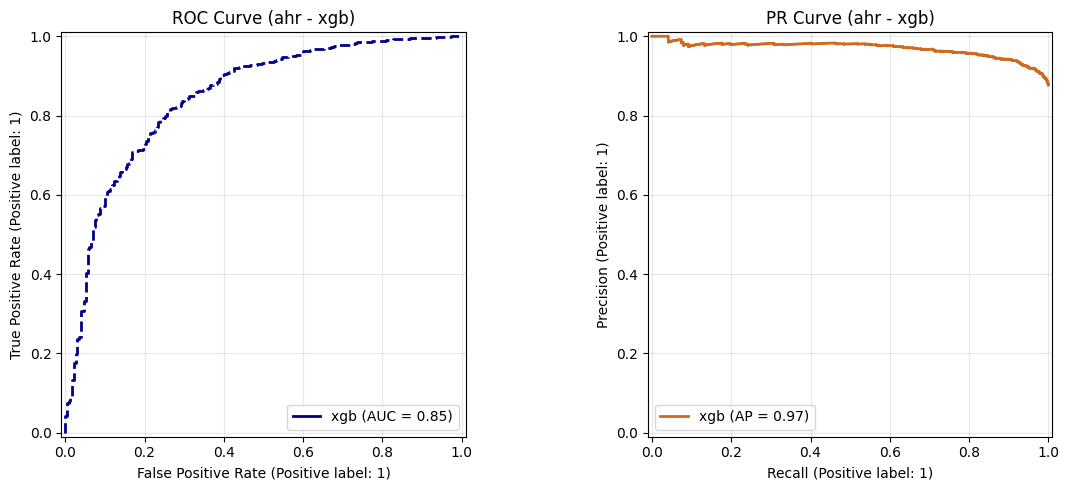

[OK] Gráficas guardadas en: /content/drive/MyDrive/QSAR/outputs/plots/roc_pr_ahr_xgb.png
Evaluación completada.


In [ ]:
# RESULTADOS DE LA EVALUACIÓN
results = evaluate_model(
    clf=clf,
    X_test=X_test,
    y_test=y_test_enc,
    model_name=model_name,
    target_name=target_name,
    label_encoder=le
)
print("Evaluación completada.")

## **10. Interpretabilidad SHAP**

Interpretabilidad SHAP para: ahr

--- Procesando: rf ---


PermutationExplainer explainer: 201it [02:04,  1.47it/s]
/tmp/ipython-input-2964617803.py:45: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_shap_arr, feature_names=feature_names, show=False)


✓ Explainer


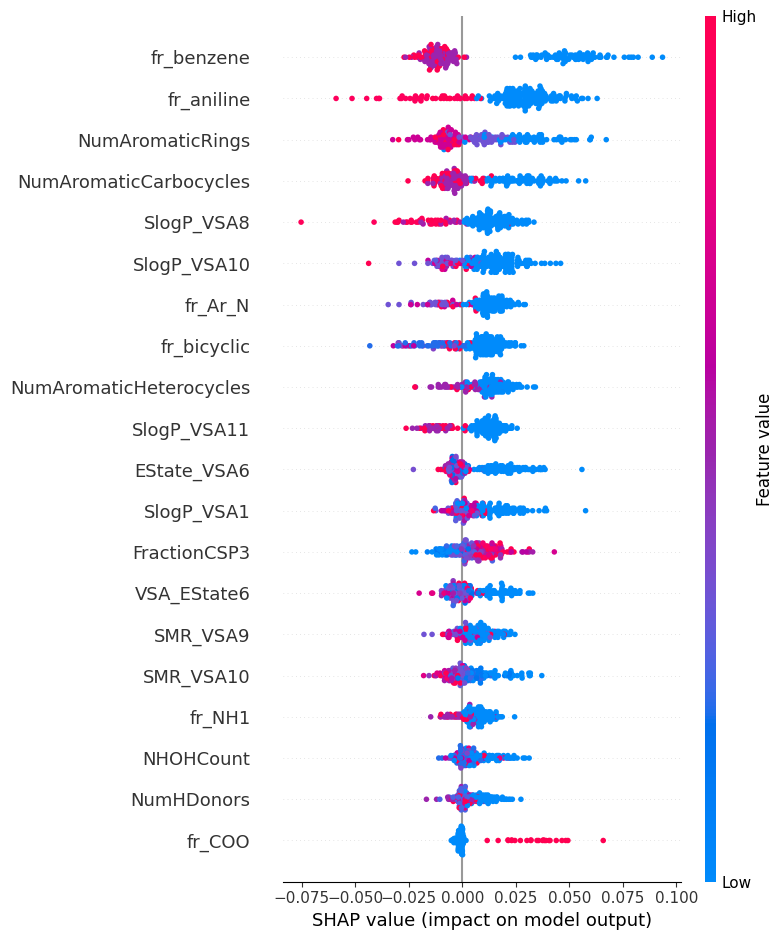

✓ Gráfico y CSV guardados para rf

--- Procesando: svm ---


PermutationExplainer explainer:  24%|██▎       | 47/200 [1:39:04<5:29:32, 129.23s/it]


KeyboardInterrupt: 

In [ ]:
import shap
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

print(f"Interpretabilidad SHAP para: {target_name}\n")

def process_model_shap(model, name, X_data, max_samples=200):
    """Procesa SHAP para un modelo individual"""
    try:
        print(f"--- Procesando: {model_name} ---")
        X_shap = X_data[:max_samples]
        X_shap_arr = X_shap.values if isinstance(X_shap, pd.DataFrame) else X_shap

        # Determinar tipo de explainer
        model_type = type(model).__name__.lower()
        tree_models = ['xgb', 'rf']
        is_tree_based = any(tree in model_type for tree in tree_models)

        # Crear explainer
        if is_tree_based:
            try:
                explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
                shap_values = explainer(X_shap_arr)
                print("✓ TreeExplainer")
            except:
                explainer = shap.Explainer(model.predict_proba, X_train)
                shap_values = explainer(X_shap_arr)
                print("✓ Explainer (fallback)")
        else:
            explainer = shap.Explainer(model.predict_proba, X_train)
            shap_values = explainer(X_shap_arr)
            print("✓ Explainer")

        # Procesar valores SHAP
        vals = np.array(shap_values.values)
        shap_vals = vals[..., 1] if vals.ndim == 3 else vals

        # Ajustar dimensiones si es necesario
        if shap_vals.shape[1] != len(feature_names):
            shap_vals = shap_vals[:, :len(feature_names)]

        # Generar gráfico y CSV
        plt.figure(figsize=(8, 12))
        shap.summary_plot(shap_vals, X_shap_arr, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f"{BASE_DIR}/outputs/plots/shap_{target_name}_{model_name}.png", dpi=300)
        plt.show()
        plt.close()

        # Exportar importancias
        importance_df = pd.DataFrame({
            "Descriptor": feature_names,
            "Mean_Abs_SHAP": np.abs(shap_vals).mean(axis=0)
        }).sort_values("Mean_Abs_SHAP", ascending=False)

        importance_df.to_csv(f"{BASE_DIR}/outputs/plots/shap_importance_{target_name}_{model_name}.csv", index=False)
        print(f"✓ Gráfico y CSV guardados para {name}\n")

    except Exception as e:
        print(f"✗ Error en {name}: {e}\n")

# Procesar todos los modelos del clasificador
def get_model_components(classifier):
    """Obtiene componentes individuales del clasificador"""
    if hasattr(classifier, 'named_estimators_') and classifier.named_estimators_:
        models = list(classifier.named_estimators_.items())
        if hasattr(classifier, 'final_estimator_'):
            models.append(('final_estimator', classifier.final_estimator_))
        return models
    return [('individual_model', classifier)]

# Ejecutar procesamiento
for model_name, model in get_model_components(clf):
    process_model_shap(model, model_name, X_test)

In [ ]:
print(feature_names)

## **11. Y-Scrambling**

In [ ]:
# Preprocesamiento


In [ ]:
tqdm.pandas()

# Y-Scrambling
scores_scramble = []
for _ in tqdm(range(20), desc="Y-Scrambling"):
    y_scrambled = np.random.permutation(y_train)
    clf.fit(X_train, y_scrambled)
    y_pred_scramble = clf.predict(X_test)
    scores_scramble.append(matthews_corrcoef(y_test, y_pred_scramble))

yscramble_results_df = pd.DataFrame({'MCC': scores_scramble})
yscramble_results_df
# Guardar DataFrame con las 20 iteraciones
yscramble_results_df.to_csv(f"{BASE_DIR}/outputs/reports/yscramble_{target_name}_{model_name}.csv", index=False)

In [ ]:
# Resultados
mean_yscramble_mcc = yscramble_results_df['MCC'].mean()
std_yscramble_mcc = yscramble_results_df['MCC'].std()
real_mcc = results['metrics_df']['MCC'].iloc[0]

print(f"Media de MCC de Y-Scrambling: {mean_yscramble_mcc:.4f}")
print(f"Desviación estándar de MCC de Y-Scrambling: {std_yscramble_mcc:.4f}")
print(f"MCC real del modelo: {real_mcc:.4f}")

# Gráfica

plt.figure(figsize=(6, 5))
sns.histplot(yscramble_results_df['MCC'], kde=True, color='skyblue', label='Y-Scrambled MCCs')
plt.axvline(mean_yscramble_mcc, color='orange', linestyle='--', label=f'Mean Y-Scrambled MCC ({mean_yscramble_mcc:.4f})')
plt.axvline(real_mcc, color='red', linestyle='-', label=f'Real MCC ({real_mcc:.4f})')

plt.title(f'Real MCC vs. Y-Scrambled MCCs ({target_name} - {model_name})')
plt.xlabel('Matthews Correlation Coefficient (MCC)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plot_path = f"{BASE_DIR}/outputs/plots/yscramble_comparison_{target_name}_{model_name}.png"
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"[OK] Gráfico de comparación de Y-Scrambling guardado en: {plot_path}")

## **12. Dominio de Aplicabilidad (AD)**

In [ ]:
# Dominio de Aplicabilidad: Williams Plot (Leverage)
hat_matrix = X_test @ np.linalg.pinv(X_train.T @ X_train) @ X_test.T
leverage = np.diag(hat_matrix)
h_star = 3 * (X.shape[1] + 1) / X.shape[0]
plt.scatter(leverage, results['y_proba'], c=y_test_enc, cmap='coolwarm')
plt.axvline(h_star, color='red', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Predicted probability')
plt.title(f'Williams Plot - AD ({target_name} - {model_name})')
plt.show()
plt.savefig(f"{BASE_DIR}/outputs/plots/ad_williams_{target_name}_{model_name}.png")
plt.close()

## **13. Predicción externa**

In [ ]:
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from IPython.display import HTML
import io
import base64

def mol_to_base64_image(mol, width=200, height=200):
    if mol is None:
        return None
    try:
        img = Draw.MolToImage(mol, size=(width, height))
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode("utf-8")
    except Exception as e:
        print(f"Error generating image for molecule: {e}")
        return None

def predict_from_smiles(smiles_list):
    processed_data = []
    original_smiles = []
    molecule_images = []
    valid_mols = []
    invalid_smiles_list = []

    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            # Standardize molecule before descriptor calculation and image generation
            lfc = rdMolStandardize.LargestFragmentChooser()
            normalizer = rdMolStandardize.Normalizer()
            reionizer = rdMolStandardize.Reionizer()
            uncharger = rdMolStandardize.Uncharger()

            def standardize(m):
                try:
                    m = lfc.choose(m)
                    m = normalizer.normalize(m)
                    m = reionizer.reionize(m)
                    m = uncharger.uncharge(m)
                    return m
                except:
                    return None

            mol_std = standardize(mol)

            if mol_std is not None:
                smiles_std = Chem.MolToSmiles(mol_std)
                descriptors = calcular_descriptores(smiles_std)

                if all(d is not None for d in descriptors):
                    processed_data.append(descriptors)
                    original_smiles.append(s)
                    valid_mols.append(mol_std)
                    molecule_images.append(mol_to_base64_image(mol_std))
                else:
                    invalid_smiles_list.append(s)
            else:
                invalid_smiles_list.append(s)
        else:
            invalid_smiles_list.append(s)

    predictions_df = pd.DataFrame(columns=['SMILES', 'Activity_Prediction', 'Probability', 'Leverage', 'AD_Flag', 'Molecule_Image'])
    if processed_data:
        raw_X_ext = np.array(processed_data)

        # Apply preprocessing steps (clean, imputer, scaler) from the trained pipeline to raw_X_ext
        X_ext_preprocessed = clf.named_steps['clean'].transform(raw_X_ext)
        X_ext_preprocessed = clf.named_steps['imputer'].transform(X_ext_preprocessed)
        X_ext_preprocessed = clf.named_steps['scaler'].transform(X_ext_preprocessed)

        # Predictions
        y_proba = clf.predict_proba(X_ext_preprocessed)[:, 1]
        y_pred_encoded = clf.predict(X_ext_preprocessed)
        y_pred_labels = le.inverse_transform(y_pred_encoded)

        # Dominio de Aplicabilidad (Leverage)
        try:
            if not isinstance(X_train, pd.DataFrame):
                X_train_df = pd.DataFrame(X_train)
            else:
                X_train_df = X_train

            num_samples_train = X_train_df.shape[0]
            num_features_train = X_train_df.shape[1]
            h_star_recalculated = 3 * (num_features_train + 1) / num_samples_train

            hat = np.diag(X_ext_preprocessed @ np.linalg.pinv(X_train_df.T @ X_train_df) @ X_ext_preprocessed.T)
            ad_flag = ['Inside AD' if h < h_star_recalculated else 'Outside AD' for h in hat]
        except Exception as e:
            print(f"Error in AD calculation: {e}")
            hat = [np.nan] * len(original_smiles)
            ad_flag = ['Error in AD'] * len(original_smiles)

        # Create DataFrame with results
        predictions_df = pd.DataFrame({
            'SMILES': original_smiles,
            'Activity_Prediction': y_pred_labels,
            'Probability': y_proba,
            'Leverage': hat,
            'AD_Flag': ad_flag,
            'Molecule_Image': molecule_images
        })

    invalid_df = pd.DataFrame({
        'Invalid_SMILES': invalid_smiles_list,
        'Reason': ['Invalid SMILES or Descriptor Calculation Failed'] * len(invalid_smiles_list)
    }) if invalid_smiles_list else pd.DataFrame(columns=['Invalid_SMILES', 'Reason'])

    return predictions_df, invalid_df

# Helper function to display DataFrame with images
def display_df_with_images(df):
    if 'Molecule_Image' in df.columns:
        html_output = df.to_html(escape=False, formatters=dict(Molecule_Image=lambda img: f'<img src="data:image/png;base64,{img}">'))
        display(HTML(html_output))
    else:
        display(df)

# Predicción de ejemplo
predictions, invalid_smiles = predict_from_smiles(['CC(=O)Nc1ccccc1C', 'invalid_smiles_string', '1', 'c1ccccc1O'])

print("\n--- Predicciones para SMILES válidos ---")
display_df_with_images(predictions)

print("\n--- SMILES inválidos o con error de cálculo de descriptores ---")
display(invalid_smiles)
